In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from pandas import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode(connected = True)
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [8]:

oil_data = pd.read_csv(r'C:\Users\patri\Downloads\oil.csv')
train = pd.read_csv(r'C:\Users\patri\Downloads\train.csv(1)\train.csv', parse_dates = True, low_memory = False, index_col = 'date')
test = pd.read_csv(r'C:\Users\patri\Downloads\test.csv (1)\test.csv')
submission_sample = pd.read_csv(r'C:\Users\patri\Downloads\submission.csv')
holidays_data = pd.read_csv(r'C:\Users\patri\Downloads\holidays_events.csv')
store_data =  pd.read_csv(r'C:\Users\patri\Downloads\stores.csv')
transaction_data = pd.read_csv(r'C:\Users\patri\Downloads\transactions.csv\transactions.csv')

train.index

DatetimeIndex(['2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01',
               ...
               '2017-08-15', '2017-08-15', '2017-08-15', '2017-08-15',
               '2017-08-15', '2017-08-15', '2017-08-15', '2017-08-15',
               '2017-08-15', '2017-08-15'],
              dtype='datetime64[ns]', name='date', length=3000888, freq=None)

In [9]:
print('Number of train samples: ', train.shape)
print('Number of test samples: ', test.shape)
print('Number of store data: ', store_data.shape)
print('Number of Holiday data: ', holidays_data.shape)
print('Number of Oil Price data: ', oil_data.shape)
print('Number of features: ', len(train.columns))
print(train.info())
print(train.columns)
print(train.head())

#shape of the data and training info

Number of train samples:  (3000888, 5)
Number of test samples:  (28512, 5)
Number of store data:  (54, 5)
Number of Holiday data:  (350, 6)
Number of Oil Price data:  (1218, 2)
Number of features:  5
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 137.4+ MB
None
Index(['id', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')
            id  store_nbr      family  sales  onpromotion
date                                                     
2013-01-01   0          1  AUTOMOTIVE    0.0          0.0
2013-01-01   1          1   BABY CARE    0.0          0.0
2013-01-01   2          1      BEAUTY    0.0          0.0
2013-01-01   3          1   BEVERAGES    0.0          0

In [10]:

train.isnull().sum()

#null values in training data

id             0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [11]:
# data extraction

train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

#get the year/month/day/week 

In [12]:
train_store=train.merge(store_data, on = 'store_nbr', how='left')
train_store.head()

#merge the training data and store data

,id,store_nbr,family,sales,onpromotion,Year,Month,Day,WeekOfYear,city,state,type,cluster
0,0,1,AUTOMOTIVE,0.0,0.0,2013,1,1,1,Quito,Pichincha,D,13
1,1,1,BABY CARE,0.0,0.0,2013,1,1,1,Quito,Pichincha,D,13
2,2,1,BEAUTY,0.0,0.0,2013,1,1,1,Quito,Pichincha,D,13
3,3,1,BEVERAGES,0.0,0.0,2013,1,1,1,Quito,Pichincha,D,13
4,4,1,BOOKS,0.0,0.0,2013,1,1,1,Quito,Pichincha,D,13


In [13]:
ts_unique = train_store.nunique()
for index, value in ts_unique.items():
    print(f"Index : {index}, Value : {value}")
    if value < 50:
        print('*'*50)
        print('keys')
        print('*'*50)
        print(train_store[index].unique())
    else:
        print('*'*50)
        print('skipping', index)
        print('More than 50 unique elements')
        print('*'*50)
        
#check for unique values

Index : id, Value : 3000888
**************************************************
skipping id
More than 50 unique elements
**************************************************
Index : store_nbr, Value : 54
**************************************************
skipping store_nbr
More than 50 unique elements
**************************************************
Index : family, Value : 33
**************************************************
keys
**************************************************
['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']
Index : sales, Value : 379610
***********************

In [16]:
import random
def random_color():
    return "#{}{}{}{}{}{}".format(*(random.choice("0123456789abcdef") for _ in range(6)))

# data

ts_sales_type = train_store.groupby('type').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)
ts_sales_family = train_store.groupby('family').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)[:20]
ts_sales_cluster = train_store.groupby('cluster').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False) 
ts_sales_state = train_store.groupby('state').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)
ts_sales_city = train_store.groupby('city').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)

#group by type/family/cluster/state/city and aggregate by the sales mean and reset the index

In [17]:
ts_sales_type['color'] = [random_color() for _ in range(len(ts_sales_type))]
ts_sales_type['color'][3:] = [random_color() for _ in range(len(ts_sales_type[3:]))]
ts_sales_family['color'] = [random_color() for _ in range(len(ts_sales_family))]
ts_sales_cluster['color'] = [random_color() for _ in range(len(ts_sales_cluster))]
ts_sales_state['color'] = [random_color() for _ in range(len(ts_sales_state))]
ts_sales_city['color'] = [random_color() for _ in range(len(ts_sales_city))]

In [18]:
import matplotlib.pyplot as plt

fig = make_subplots(rows=5, cols=2, 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None],
                           [{"type": "pie"},{"type": "bar"} ],
                           [{"colspan": 2}, None],
                           [{"colspan": 2}, None]],
                    column_widths=[0.5, 0.5], vertical_spacing=0, horizontal_spacing=0.02,
                    subplot_titles=("Average Product Sales", 
                                    "Highest Average Sales in Store Types",
                                    "\n",
                                    "\n"
                                    "Average Sales per State",
                                    "Average Sales per Cluster",
                                    "\n",
                                    "\n"
                                    "Average Sales per City",
                                   ))
fig.add_trace(go.Bar(x=ts_sales_family['sales'], 
                     y=ts_sales_family['family'],
                     marker=dict(color= ts_sales_family['color']),
                     name='Family', orientation='h'), 
                     row=1, col=1)
fig.add_trace(go.Pie(values=ts_sales_type['sales'], labels=ts_sales_type['type'], name='Store Type',
                     marker=dict(colors= ts_sales_family['color']), hole=0.4+(0.1 * random.randrange(-2, 2)),
                     hoverinfo='label+percent+value', textinfo='label'),row=1, col=2)
fig.add_trace(go.Bar(x=ts_sales_cluster['sales'], 
                     y=ts_sales_cluster['cluster'],
                     marker=dict(color= ts_sales_cluster['color']),
                     name='Cluster', orientation='h'), 
                     row=3, col=2)
fig.add_trace(go.Pie(values=ts_sales_state['sales'], labels=ts_sales_state['state'], name='State',
                     marker=dict(colors= ts_sales_state['color']), hole=0.4+(0.1 * random.randrange(-2, 2)),
                     hoverinfo='label+percent+value', textinfo='label'),row=3, col=1)
fig.add_trace(go.Bar(x=ts_sales_city['city'], y=ts_sales_city['sales'], 
                     marker=dict(color= ts_sales_city['color']), name='City'), 
                     row=5, col=1)
fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(visible=False, row=3, col=2)
fig.update_xaxes(tickmode = 'array', tickvals=ts_sales_cluster.cluster, ticktext=[i for i in range(1,17)], row=3, col=2)
fig.update_yaxes(visible=False, row=5, col=1)
plt_themes = ["plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"]
fig.update_layout(height=1800, bargap=0.3,
                  margin=dict(b=10,r=20,l=20), 
                  xaxis=dict(tickmode='linear'),
                  title_text="Average Sales Analysis",
                  title_x=0.5,
                  template=plt_themes[random.randrange(0, 6)],
                  title_font=dict(size=25, color=random_color(), family="Roboto, sans-serif"),
                  font=dict(color=random_color()),
                  hoverlabel=dict(bgcolor=random_color(), font_size=15, font_family="Roboto, sans-serif"),
                  showlegend=False)
fig.show()

Text(0.5, 0, 'Promotions')

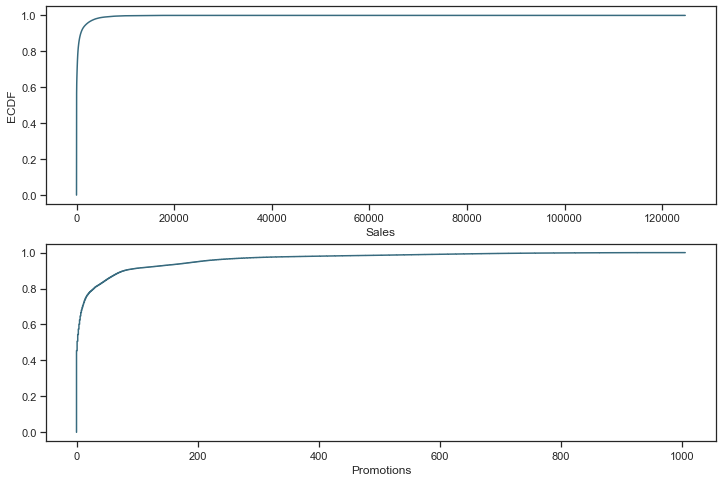

In [19]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 8))

plt.subplot(211)
cdf = ECDF(train['sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c)
plt.xlabel('Sales')
plt.ylabel('ECDF')

# plot second ECDF  
plt.subplot(212)
cdf = ECDF(train['onpromotion'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c)
plt.xlabel('Promotions')

In [20]:
store_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [21]:
store_data.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [22]:
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
train_store = pd.merge(train, store_data, how = 'inner', on = 'store_nbr')

print("In total: ", train_store.shape)
train_store.head()

Joining train set with an additional store information.
In total:  (3000888, 13)


,id,store_nbr,family,sales,onpromotion,Year,Month,Day,WeekOfYear,city,state,type,cluster
0,0,1,AUTOMOTIVE,0.0,0.0,2013,1,1,1,Quito,Pichincha,D,13
1,1,1,BABY CARE,0.0,0.0,2013,1,1,1,Quito,Pichincha,D,13
2,2,1,BEAUTY,0.0,0.0,2013,1,1,1,Quito,Pichincha,D,13
3,3,1,BEVERAGES,0.0,0.0,2013,1,1,1,Quito,Pichincha,D,13
4,4,1,BOOKS,0.0,0.0,2013,1,1,1,Quito,Pichincha,D,13


<AxesSubplot:xlabel='sales', ylabel='family'>

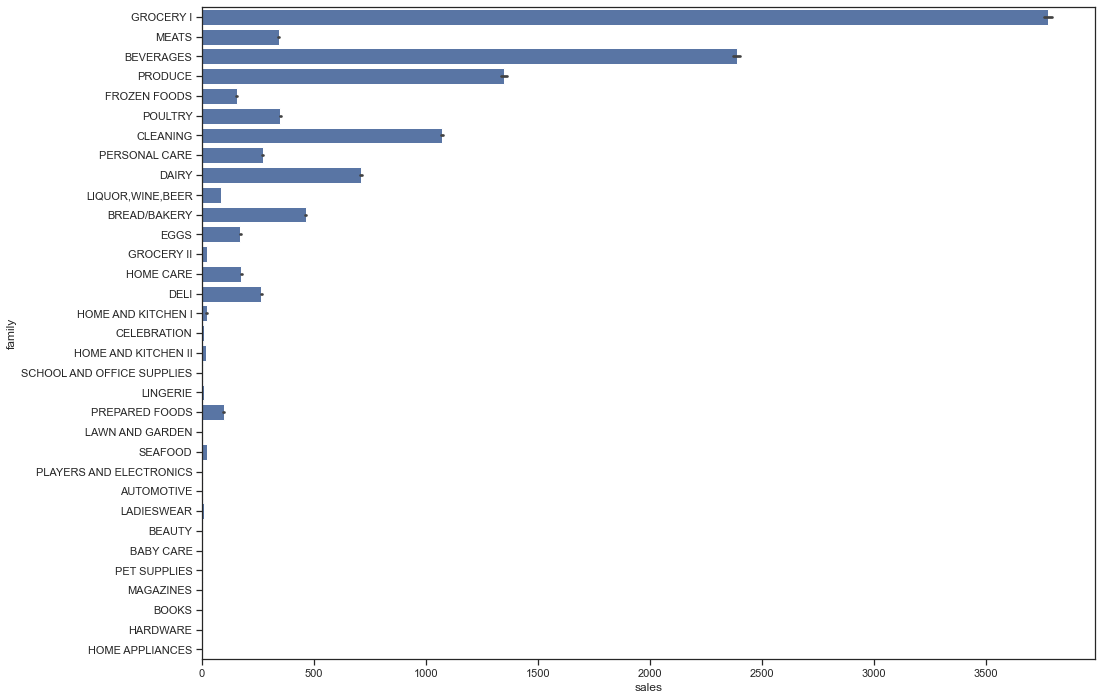

In [23]:
plt.figure(figsize=(16,12))
sns.barplot(x="sales", y="family", data=train_store.sort_values(by=['sales','family'], ascending=False),
            label="Sales", color="b")

<AxesSubplot:title={'center':'Counts of type of holiday'}, xlabel='locale', ylabel='count'>

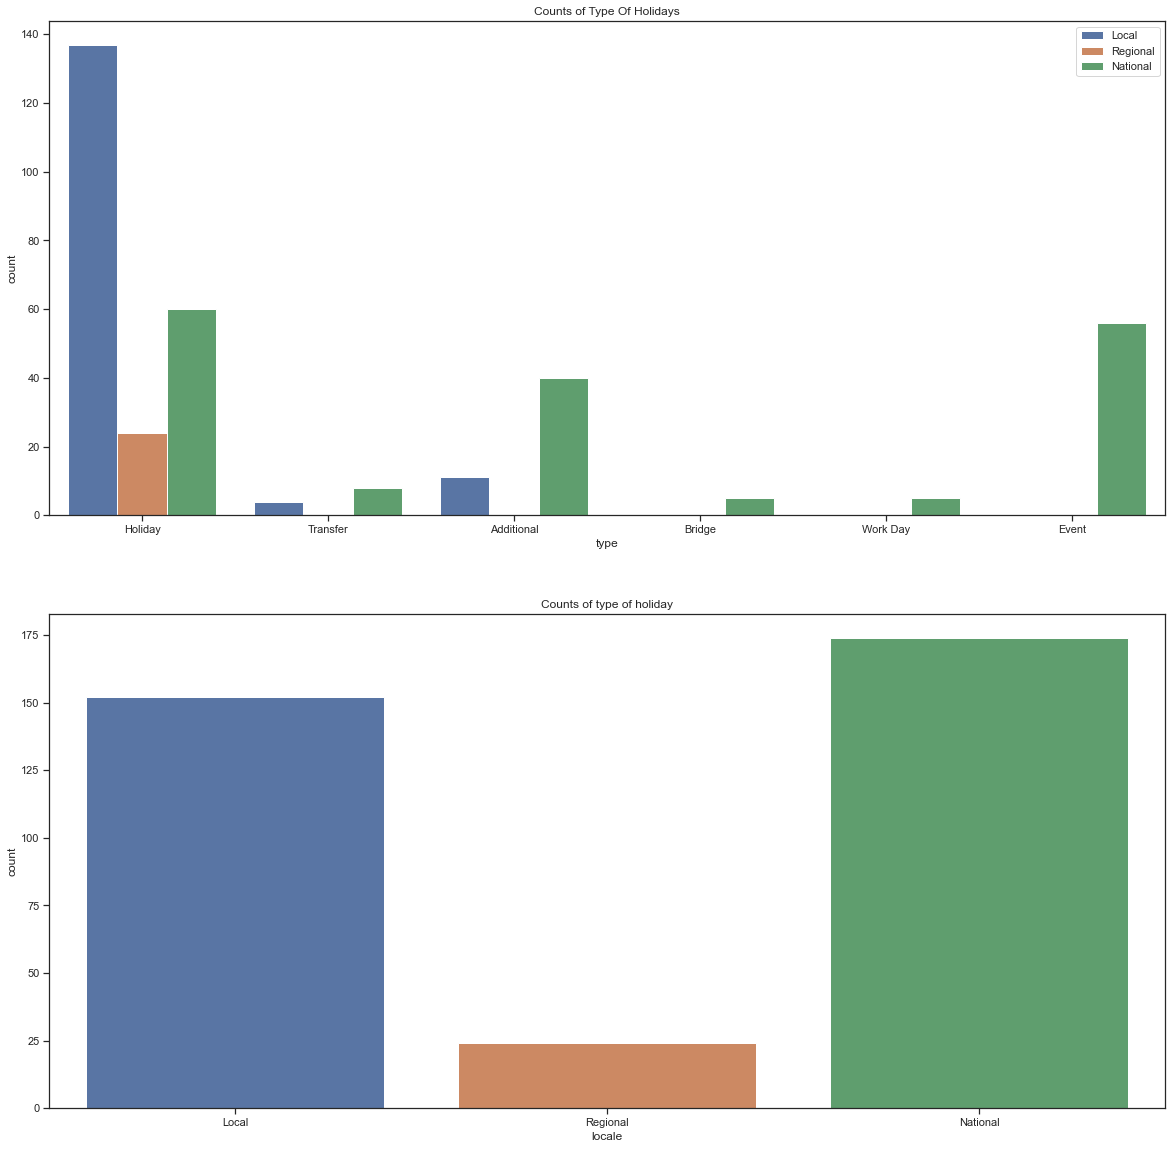

In [25]:
plt.subplots(1,2,figsize=(20,20))
plt.subplot(211)
plt.title('Counts of Type Of Holidays')
sns.countplot(x=holidays_data.type, hue=holidays_data.locale)
plt.legend(loc='upper right')
plt.subplot(212)
plt.title('Counts of type of holiday')
sns.countplot(x=holidays_data.locale)

<AxesSubplot:xlabel='count', ylabel='city'>

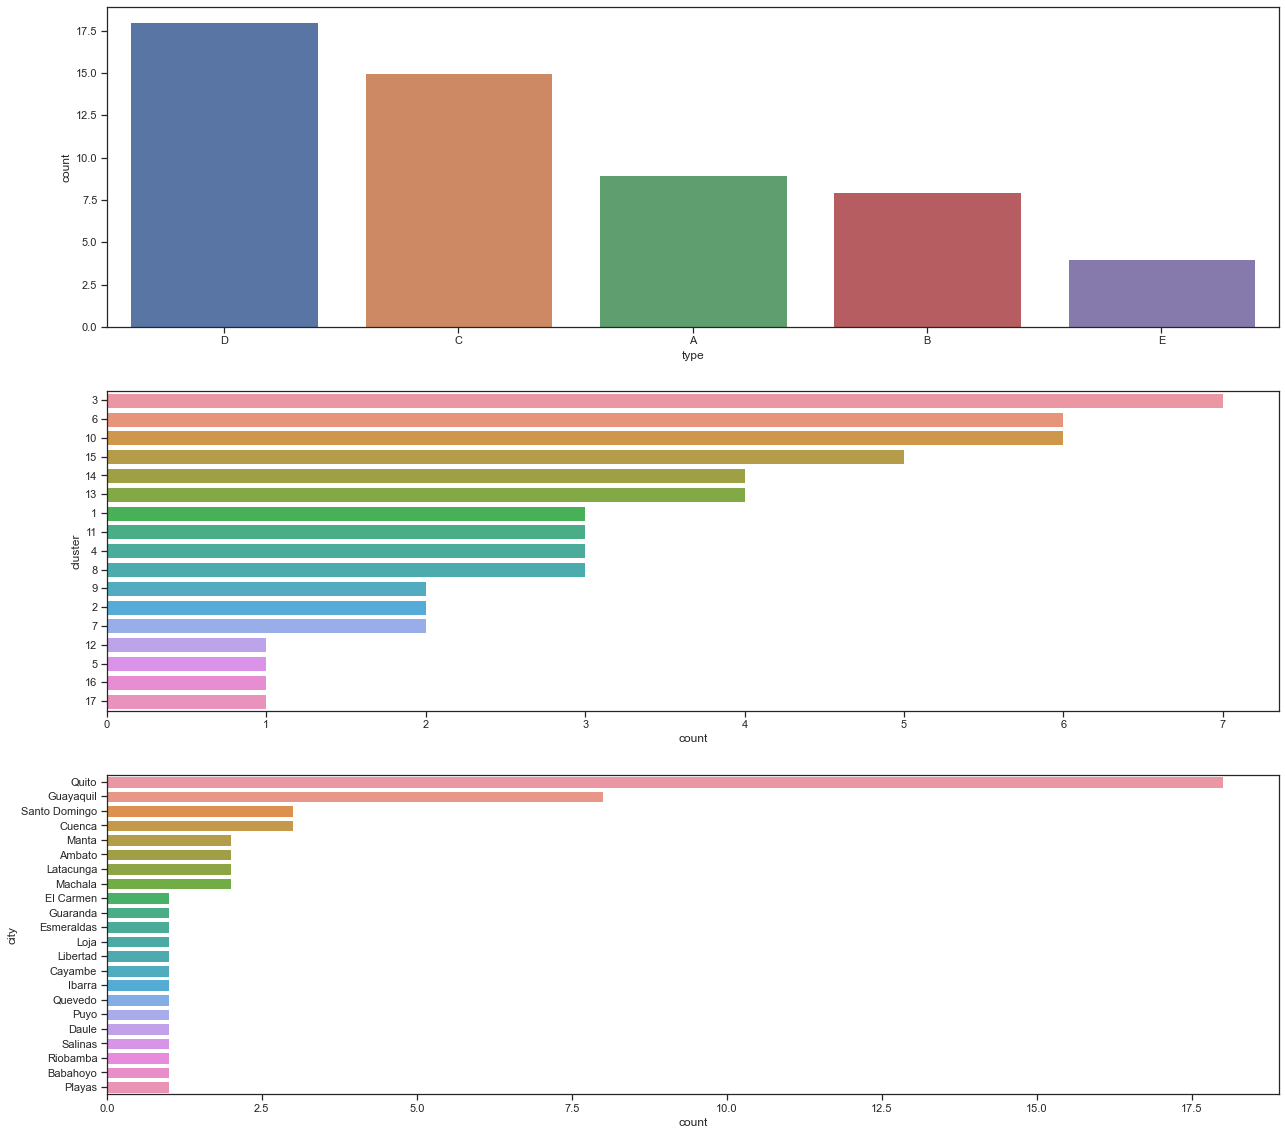

In [27]:
plt.subplots(1,3,figsize=(21,20))
plt.subplot(311)
sns.countplot(x=store_data.type, order = store_data.type.value_counts().index)
plt.subplot(312)
sns.countplot(y=store_data.cluster, order = store_data.cluster.value_counts().index)
plt.subplot(313)
sns.countplot(y=store_data.city, order = store_data.city.value_counts().index)

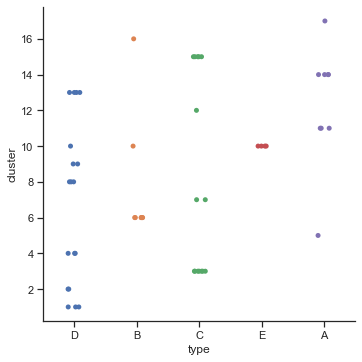

In [29]:
sns.catplot(x = 'type', y='cluster',data=store_data, kind='strip')

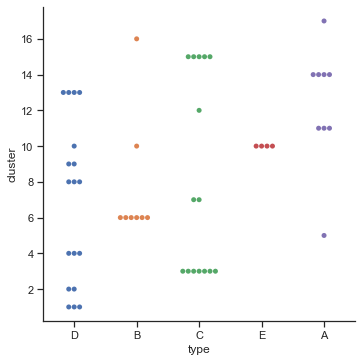

In [30]:
sns.catplot(x = 'type', y='cluster',data=store_data, kind='swarm')

In [31]:
train_store.groupby('state')['city','type','sales'].sum()

,sales
state,
Azuay,4.916860e+07
Bolivar,1.304951e+07
Chimborazo,1.138792e+07
Cotopaxi,2.118226e+07
El Oro,3.338680e+07
Esmeraldas,1.639169e+07
Guayas,1.651544e+08
Imbabura,1.145127e+07
Loja,1.886000e+07


In [32]:
train_store.groupby('city')['state','type','sales'].sum()

,sales
city,
Ambato,4.030440e+07
Babahoyo,1.774687e+07
Cayambe,2.832556e+07
Cuenca,4.916860e+07
Daule,1.918802e+07
El Carmen,1.105748e+07
Esmeraldas,1.639169e+07
Guaranda,1.304951e+07
Guayaquil,1.229673e+08


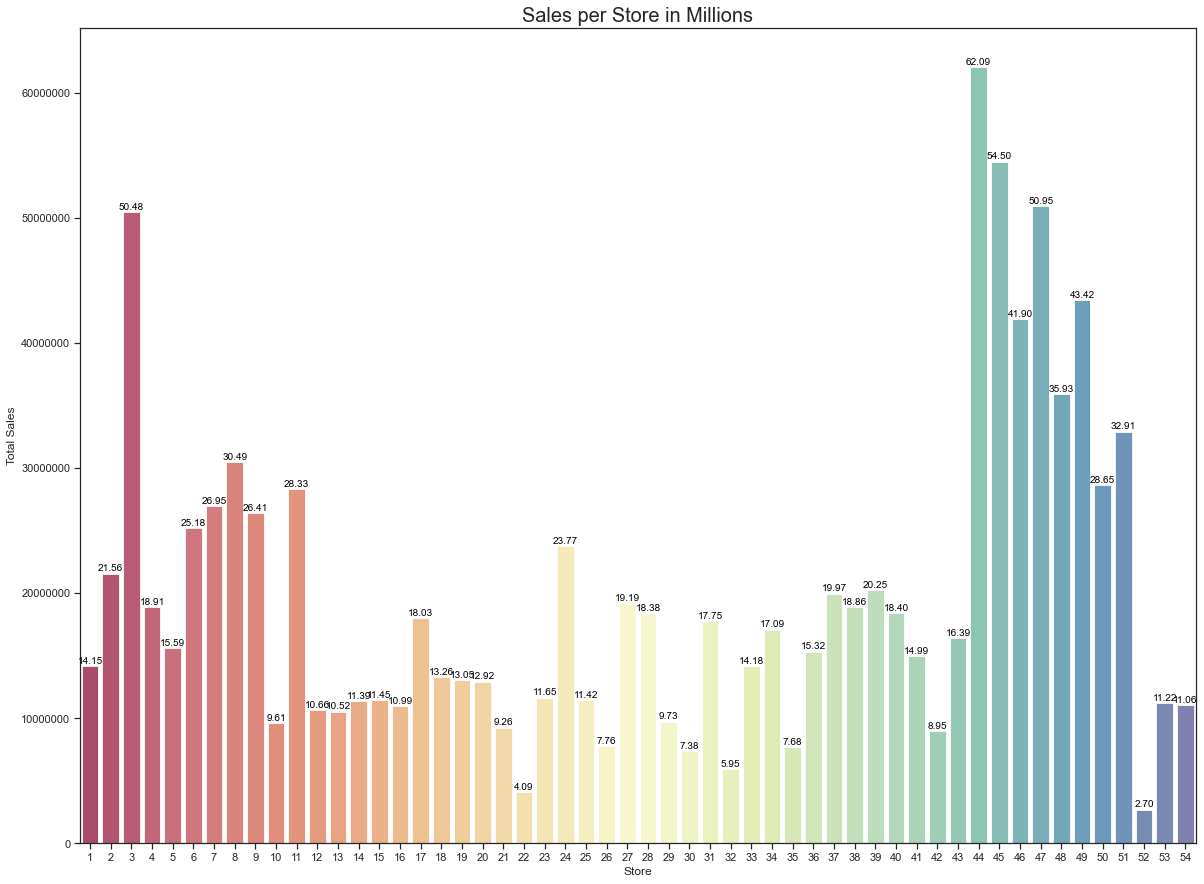

In [33]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
x=train_store.groupby('store_nbr')['city','type','sales'].sum()
x=x.sort_values(by='sales',ascending=False)
x=x.iloc[0:55].reset_index()

plt.figure(figsize=(20,15))
ax= sns.barplot( x.store_nbr ,x.sales, alpha=0.8,  palette="Spectral")
# annotation here
for p in ax.patches:
    ax.annotate("%.2f" % round((p.get_height()/1000000),2), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')


plt.ticklabel_format(style='plain', axis='y')
plt.title("Sales per Store in Millions", fontsize=20)
plt.ylabel('Total Sales', fontsize=12)
plt.xlabel('Store', fontsize=12)
plt.show()